In [15]:
import pandas as pd
import yfinance as yf

yf.pdr_override()
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from pandas_datareader import data, wb
import scipy.optimize as sco

""" Stocks tickers, starting date and end date to assess our portfolio"""

stocks = ['AAPL', 'MSFT', 'AVGO', 'NVDA', 'ADBE']
start_date = '2013-01-01'
end_date = '2023-12-01'

"""Creation of dataframe to retrieve stock information"""

stocks_data = pd.DataFrame()

""" Download stock data into a list"""

for stock_symbol in stocks:
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    stocks_data[stock_symbol] = stock_data['Close']

noa = len(stocks)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

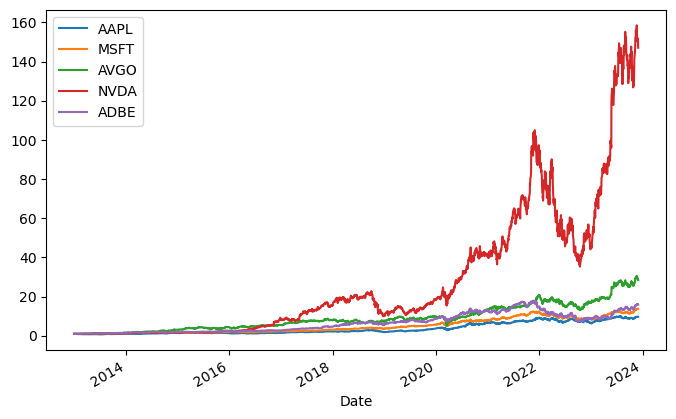

In [2]:
(stocks_data / stocks_data.iloc[0]).plot(figsize=(8, 5))

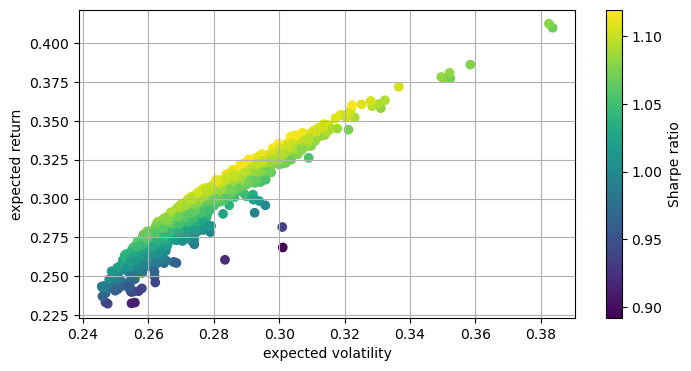

In [3]:
rets = np.log(stocks_data / stocks_data.shift(1))
rets.mean() * 252
rets.cov() * 252

"""Generating random portfolio weights and calculate returns and volatility"""

weights = np.random.random(noa)
weights /= np.sum(weights)

"""MC simulation for portfolio optimization"""

p_rets = []
p_vols = []

for p in range(1000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    p_rets.append(np.sum(rets.mean() * weights) * 252)
    p_vols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
p_rets = np.array(p_rets)
p_vols = np.array(p_vols)

"""Define function for portfolio statistics and optimization"""

plt.figure(figsize=(8, 4))
plt.scatter(p_vols, p_rets, c=p_rets / p_vols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [4]:
def statistics(weights):
    weights = np.array(weights)
    p_ret = np.sum(rets.mean() * weights) * 252
    p_vol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

    return np.array([p_ret, p_vol, p_ret / p_vol)


"""Minimizing the negative of the Sharpe Ratio"""


def min_func_sharpe(weights):
    return -statistics(weights)[2]


"""Specifying the constraints of our optimisation problem"""


def sum_constraint(x):
    return np.sum(x) - 1


In [5]:

"""Add our clients' investment condition (max weight per stock= 0.4)"""

cons = ({'type': 'eq', 'fun': sum_constraint},
        {'type': 'ineq', 'fun': lambda w: 0.4 - w})
bnds = tuple((0, 1) for x in range(noa))

"""Kick start optimisation algorithm"""

# noa * [1. / noa, ]
opts = sco.minimize(min_func_sharpe, noa * [1. / noa, ], method='SLSQP',
                    bounds=bnds, constraints=cons)
# opts
# opts['x'].round(3)
# statistics(opts['x']).round(3)

"""Weights for each stock"""

print("The optimized weight for each of the recommended stock is:")

# opt_string = (
#     f"-{stocks[0]}:{opt_s[0]} \n"
#     f"-{stocks[1]}:{opt_s[1]} \n"
#     f"-{stocks[2]}:{opt_s[2]} \n"
#     f"-{stocks[3]}:{opt_s[3]} \n"
#     f"-{stocks[4]}:{opt_s[4]}"
# )
# print(opt_string)

"""Minimising the volatility of our portfolio"""
for n in range(len(stocks)):
    print(f"-{stocks[n]}:{opts['x'][n].round(3)}")





The optimized weight for each of the recommended stock is:
-AAPL:0.0
-MSFT:0.3
-AVGO:0.273
-NVDA:0.381
-ADBE:0.046


In [7]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

optv = sco.minimize(min_func_variance, noa * [1. / noa, ],
                    method='SLSQP', bounds=bnds, constraints=cons)
# optv
# optv['x'].round(3)
# statistics(optv['x']).round(3)

for n in range(len(stocks)):
    print(f"-{stocks[n]}:{optv['x'][n].round(3)}")

"""Highlighting the statistics of the portfolio"""

print("Key statistics of your portfolio:")

# opt_string2 = (
#     f"Expected return: {sto_stats[0]}; \nVolatility: {sto_stats[1]};\n"
#     f"Sharpe ratio: {sto_stats[2]}."
# )
# print(opt_string2)

-AAPL:0.347
-MSFT:0.4
-AVGO:0.117
-NVDA:0.0
-ADBE:0.136
Key statistics of your portfolio:


In [12]:

"""Calculate efficient frontier"""

def min_func_port(weights):
    return statistics(weights)[1]


trets = np.linspace(0.230, 0.300, 50)
tvols = []


def return_constraint(weights):
    return statistics(weights)[0] - tret


tvols = []
for tret in trets:
    cons = ({'type': 'ineq', 'fun': lambda w: 0.4 - w},
            {'type': 'eq', 'fun': sum_constraint},
            {'type': 'eq', 'fun': return_constraint})
    res = sco.minimize(min_func_port, noa * [1. / noa, ], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
    
for n in range(len(stocks)):
    print(f"-{stocks[n]}:{res['x'][n].round(3)}")

-AAPL:0.107
-MSFT:0.362
-AVGO:0.234
-NVDA:0.213
-ADBE:0.084


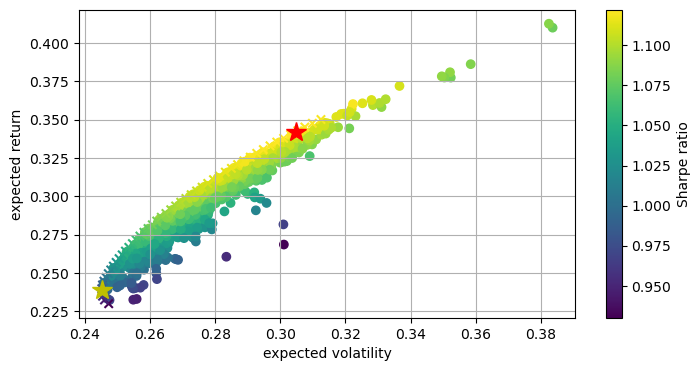

In [11]:
tvols = np.array(tvols)

plt.figure(figsize=(8, 4))
plt.scatter(p_vols, p_rets, c=p_rets / p_vols, marker='o')
plt.scatter(tvols, trets, c=trets / tvols, marker='x')
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')